In [1]:
import os
from pySMOKEPostProcessor import KineticMap
from pySMOKEPostProcessor import PostProcessor
from pySMOKEPostProcessor import FluxByClass
from pySMOKEPostProcessor import FDI, assignclass, merge_maps_byspecies
from pySMOKEPostProcessor import plot_heatmap
#from pySMOKEPostProcessor import save_fig

# Rate Of Production Analysis by Reaction Class
The rate of production analysis can be organized according to reaction classes. Different levels of classification are available:

> * `Class type`: defined by the user in **rxn_class_groups.txt** text file (see data/Classes). Broad classification (e.g., bond-fission, H-abstraction, growth)
> * `Reaction type`: reaction channels belonging to a certain class type. These are listed within the class types in the text file. They must also be present in the **kinetics.xml** file (hard coded)
> * `Species type`: type of species that defines the functional group participating to the reaction (e.g., A1-M is the aromatic ring in its molecular form, A1-R is a phenyl-like radical)
> * `Bimolecular type`: classification according to unimolecular/bimolecular reaction type, accounting for the nature of the reacting species (M, R, RSR: molecule, radical, resonance-stabilized radical). This classification does not require specific input.

Required input for the different steps

* `FluxByClass`: class that handles the classification of reactions. Input arguments are:
    > * `kin_xml_fld` (*str*): path to the folder containing the files relative to the kinetic mechanism named directly, after the pre-processing by OpenSMOKE++: **kinetics.xml** and **reaction_names.xml**.
    > * `class_groups` (*str*): path to file **rxn_class_groups.txt** (or other name) with the groups.
    
* `FluxByClass.process_flux`: assigns the reaction flux according to the user requests. for now, only global flux analysis is available. This function calls the pySMOKEpostprocessor.RateOfProductionAnalysis. Input arguments are:
    > * `species_list` (*list*): list of species to perform ROPA for; accepts strings or dictionaries if you want to sum up fluxes for more than one species. Example {'PAH': ['C10H8', 'INDENE' ,'BIPHENYL']} sums the flux of these 3 species and names it "PAH" in the heatmap
    > * `simul_fld` (*str*): path to the folder containing OpenSMOKE++ output simulation files. **Output.xml** is required.
    > * `ropa_type` (*str*): type of ROPA (global is the only available option for now).
    > * `n_of_rxns` (*int*, default: 100): number of reactions to be included in the flux analysis (from those with the highest flux).
    

* `FluxByClass.sort_and_filter`: organizes classes for each species flux by reaction class and sums fluxes in the same class. filters classes (i.e., reduces the set of reactions considered) by user-defined criteria. requires:
    > * `sortlist` (*list(str)*): criteria to be considered hierarchically for reaction flux sorting. allowed strings: **classtype,speciestype,reactiontype,bimoltype**. For instance, ['speciestype','reactiontype'] groups reactions according to species type, and within that set the reactions are grouped according to reaction type.
    > * `filter_dct` (*dict: list(str)*, default: {}):filtering for set of classes. dictionary keys correspond to criteria allowed for sortlist, and the value is a list of strings that have to be contained in the class filtered. For instance, {'classtype':['ADD','ABS']} filters all reactions whose classtype includes either 'ADD' or 'ABS' (i.e., abstractions and addition reactions).
    > * `threshold` (*float*, default: 1e-3): minimum relative flux to be considered in the classification. Reactions with smaller flux will be removed.
    > * `weigheach` (*bool*, default: True): weigh the flux of each species according to the maximum absolute flux.

* `plot_heatmap`: plots heat maps according to the dataframe provided
    > * `sortdf` (*pandas dataframe*): flux according to species (column) and reaction class (row)
    > * `symmetricaxis` (*bool*, default: False): decide how to scale the colorbar for plotting. True: 0 is in the middle, and the axis is symmetric with respect to minimum and maximum values. False: axis shifted according to where the 0 is.

In [2]:
kin_xml_fld = os.path.join('..', 'data', 'Classes', 'kinetics')
class_groups_fld = os.path.join('..', 'data', 'Classes', 'rxn_class_groups.txt')
plt_fld = os.path.join('..', 'Figures')
simul_flds ={'example-c6h6' : os.path.join('..', 'data', 'Classes', 'simul', 'Output')}

sim_flds_toFDI = {'1100': os.path.join('..', 'data', 'Classes', 'simul', 'Output'),
                  '1300': os.path.join('..', 'data', 'Classes', 'simul2', 'Output'),
                  '1500': os.path.join('..', 'data', 'Classes', 'simul3', 'Output')}


In [3]:
# generic function for processing
def get_sortedrxns(kin_xml_fld, class_groups_fld):
    km = KineticMap(kin_xml_fld,)
    rxns_sorted, _ = assignclass(km, class_groups_fld)
    return rxns_sorted
    
def process_classes(simul_fld,
            kin_xml_fld,
            rxns_sorted,
            species_list,
            sortlists,
            ropa_type,
            n_of_rxns = 100,
            filter_dcts = None,
            threshs = None,
            weigh = 'normbyspecies',
            local_value = 0.,
            upper_value = 0.,
            lower_value = 0.,
            mass_ropa = False,
            ):
    
    sortdfs = []
    
    if filter_dcts == None:
        filter_dcts = [{}]*len(sortlists)
    if threshs == None:
        threshs =  [1e-3]*len(sortlists)

    # pp -- for ropa
    pp = PostProcessor(kin_xml_fld, simul_fld)
    # initialize
    fluxbyclass = FluxByClass(rxns_sorted)

    # ROPA for each species - if species_list contains dictionary, extract flux for each
    if isinstance(species_list[0], dict):
        flat_species_list = sum([list(d.values())[0] for d in species_list], [])
    else:
        flat_species_list = species_list
        
    tot_rop_dct = dict.fromkeys(flat_species_list)
    for sp in flat_species_list:
        tot_rop_dct[sp] = pp.RateOfProductionAnalysis(sp,
                                                    ropa_type,
                                                    local_value = local_value,
                                                    lower_value=lower_value,
                                                    upper_value=upper_value,
                                                    number_of_reactions=n_of_rxns,
                                                    mass_ropa=mass_ropa)

    # assign flux and process according to selected criteria
    fluxbyclass.process_flux(species_list, tot_rop_dct)
    for i, sortlist in enumerate(sortlists):
        # assign flux and process according to selected criteria
        sortdf = fluxbyclass.sort_and_filter(sortlist,
                                             filter_dct = filter_dcts[i],
                                             thresh = threshs[i],
                                             weigh = weigh)
        
        sortdfs.append(sortdf)

    return sortdfs


In [4]:
# sort the reactions - same for all examples
rxns_sorted = get_sortedrxns(kin_xml_fld, class_groups_fld)

### Example 0: 
reactions are classified according to reactiontype; all parameters set to default

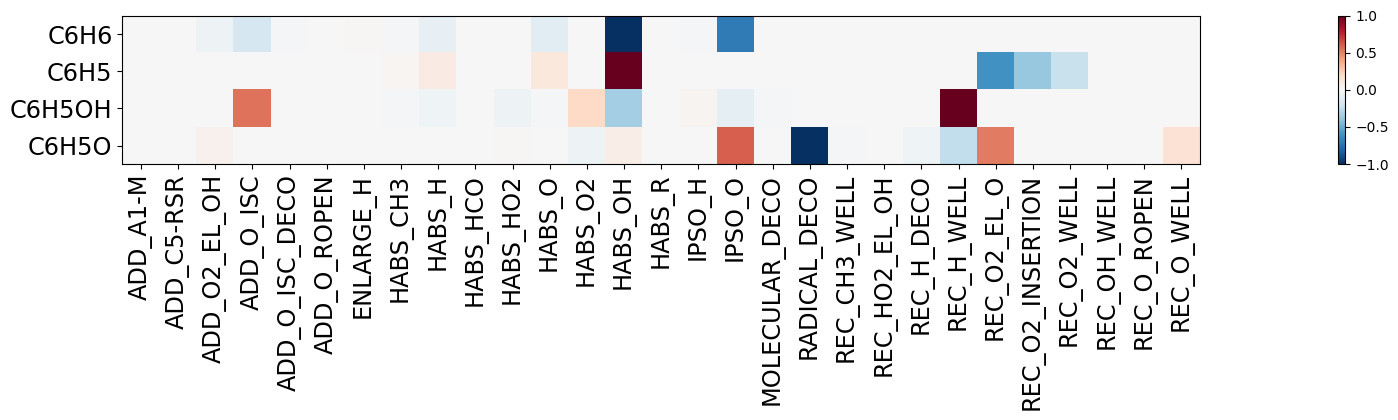

In [20]:
# additional type of classification: filter addition and abstraction reactions
species_list =['C6H6','C6H5','C6H5OH', 'C6H5O']
sortlists = [['reactiontype']] # classtype, speciestype, reactiontype, bimoltype (R+R, RSR+RSR, M+M, ETC) sum if both apply and sort by this criteria
# specify ropa options
ropa_type = 'global'
for simul_name, simul_fld in simul_flds.items():
    sortdfs = process_classes( 
                simul_fld, 
                kin_xml_fld, 
                rxns_sorted,
                species_list,
                sortlists,
                ropa_type,
                n_of_rxns = 20,)
# plot heatmap
fig = plot_heatmap(sortdfs[0], symmetricaxis = True, dftype = 'flux')

### Example 1 - global flux analysis by class/species/bimol. types: 
reactions are classified according to classtype, speciestype, ans bimoltype. The threshold to filter the flux is 0.1%.

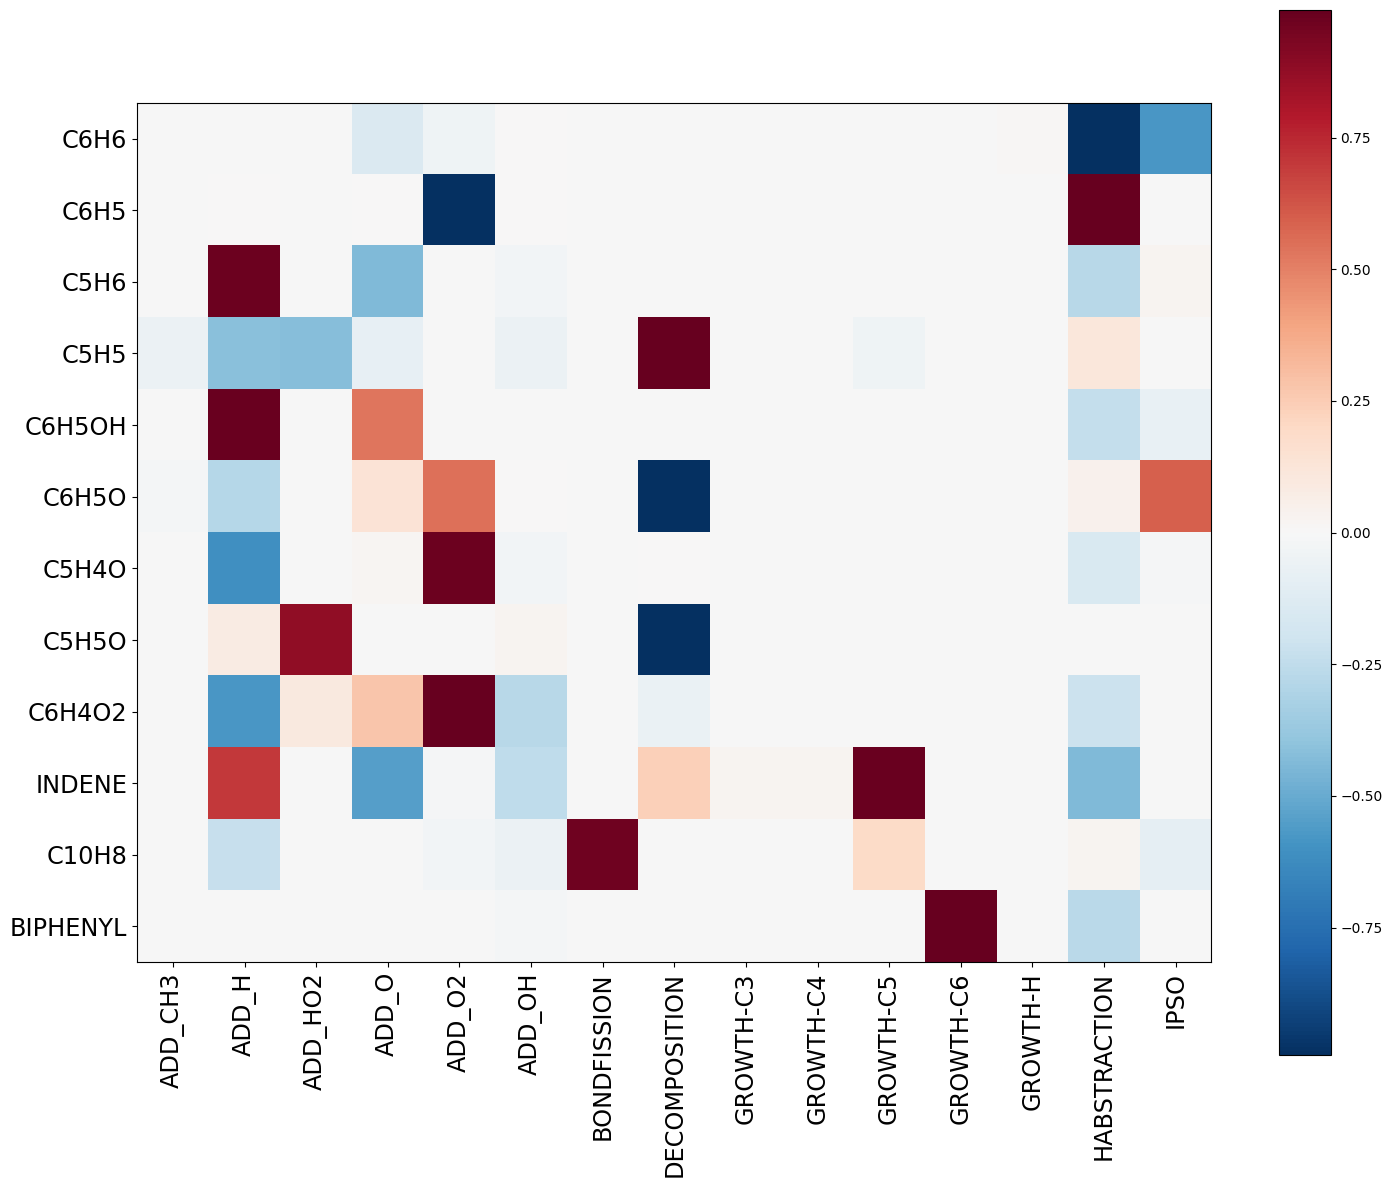

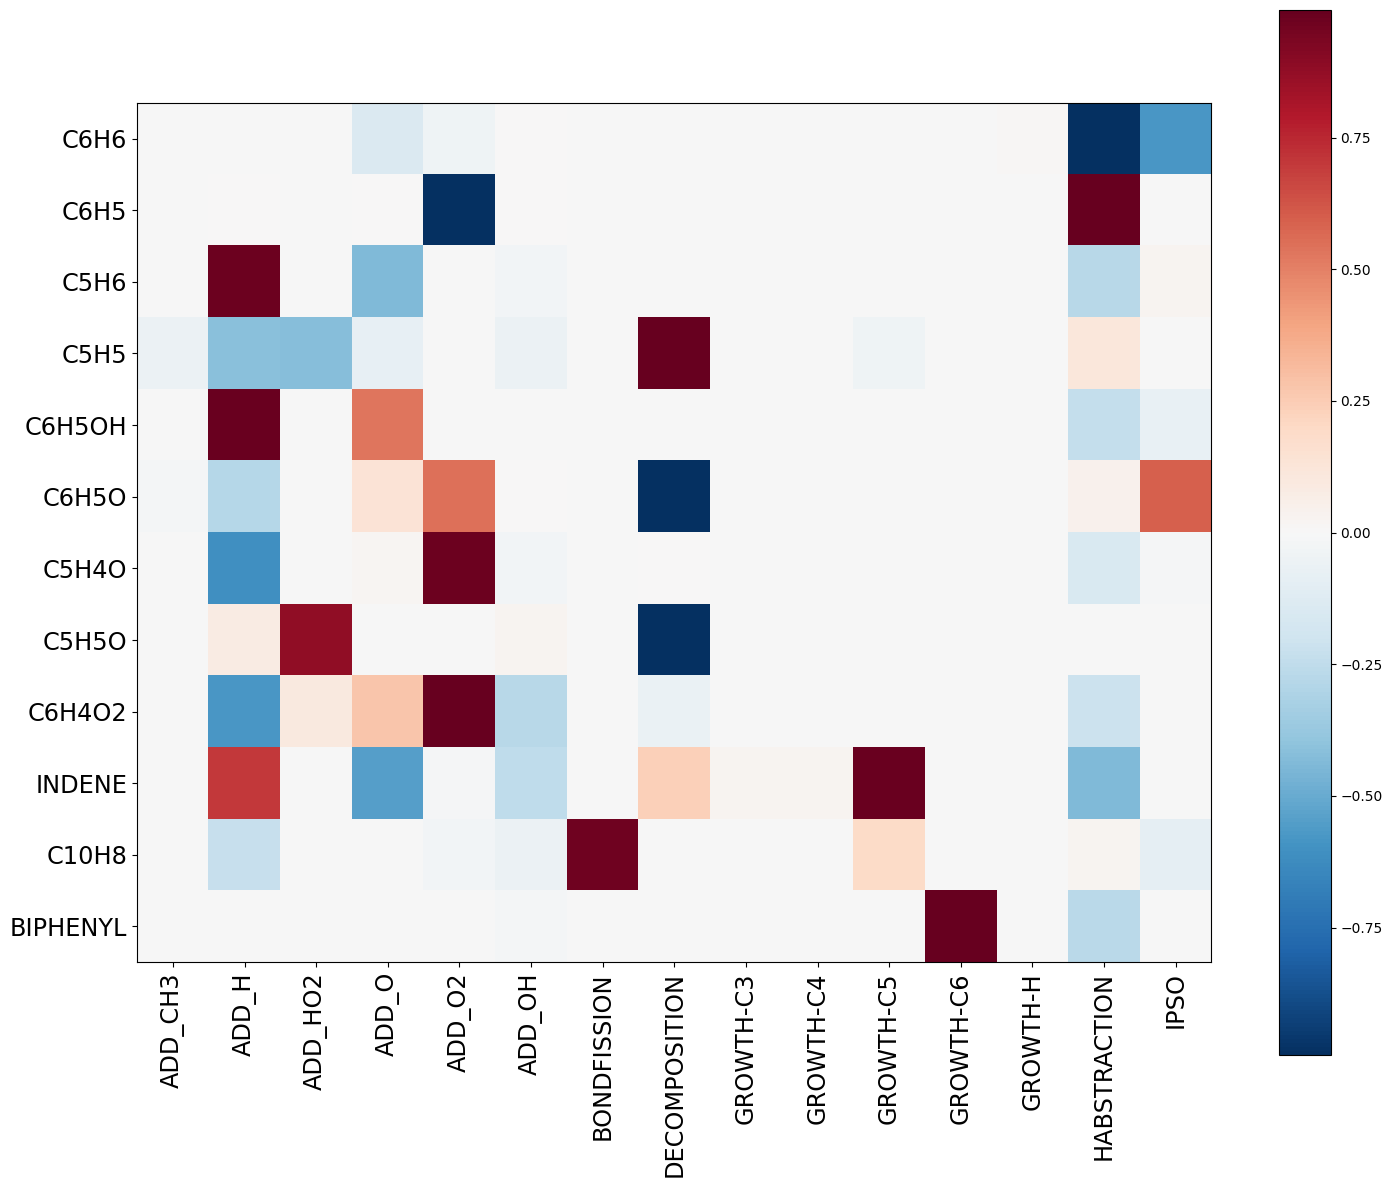

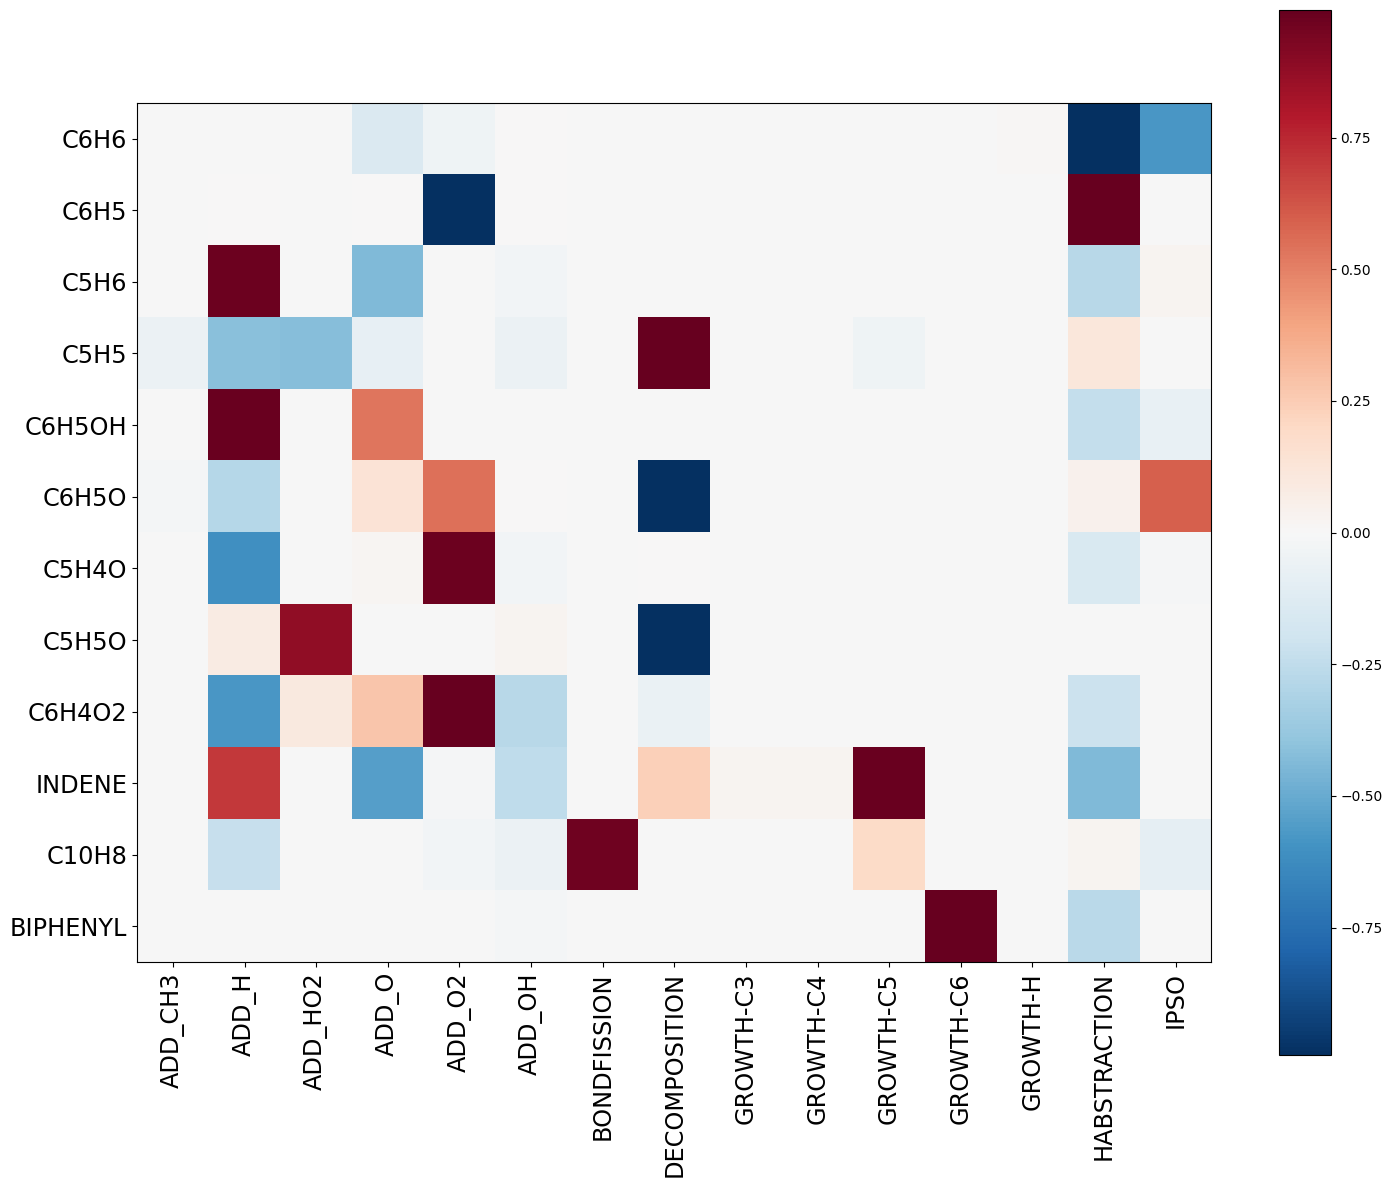

In [21]:
species_list =['C6H6','C6H5','C5H6','C5H5','C6H5OH','C6H5O','C5H4O','C5H5O','C6H4O2','INDENE','C10H8','BIPHENYL']
threshs = [1e-2,1e-2,1e-2] # threshold for minimum flux - default 1e-3
n_of_rxns = 200            # max n of rxns to consider for flux (default: 100)
sortlists = [['classtype'],['speciestype'],['bimoltype']] # classtype, speciestype, reactiontype, 
                                                          # bimoltype (R+R, RSR+RSR, M+M, ETC) 
                                                          # sum if both apply and sort by this criteria
ropa_type='global'

sortdfs = process_classes(simul_fld, 
            kin_xml_fld, 
            rxns_sorted,
            species_list,
            sortlists,
            ropa_type,
            threshs = threshs,
            n_of_rxns=n_of_rxns)

# plot heatmaps
for sorted in sortdfs:
    plot_heatmap(sortdfs[0], symmetricaxis = True, dftype = 'flux')

### Example 2 - global flux analysis with hierarchical double classification: 
reactions are now classified hierarchically according to [classtype][bimoltype]. The reactions are filtered such that only additions and abstraction reactions (of additions and abstraction class types) are considered. The threshold to filter the flux is 0.1%.

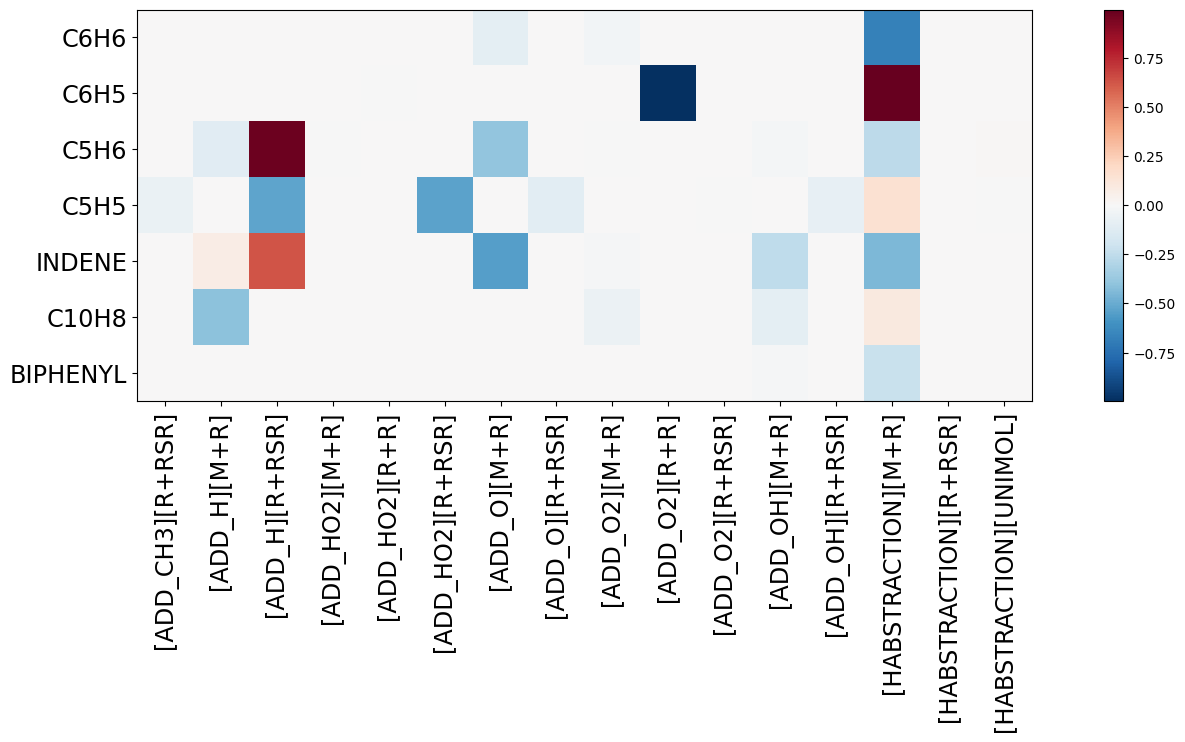

In [22]:
# additional type of classification: filter addition and abstraction reactions
species_list =['C6H6','C6H5','C5H6','C5H5','INDENE','C10H8','BIPHENYL']
filter_dcts = [{'classtype':['ADD', 'HABS']}] # filter according to selected criteria in name
# thresh = 1e-3 # threshold for minimum flux
sortlists = [['classtype','bimoltype']] # classtype, speciestype, subclass, bimoltype (R+R, RSR+RSR, M+M, ETC) sum if both apply and sort by this criteria
ropa_type = 'global'
for simul_name, simul_fld in simul_flds.items():
    sortdfs = process_classes(simul_fld, 
                kin_xml_fld, 
                rxns_sorted,
                species_list,
                sortlists,
                ropa_type,
                filter_dcts=filter_dcts)
# plot heatmap
fig = plot_heatmap(sortdfs[0], symmetricaxis = True, dftype = 'flux')

### Example 3 - flux analysis in a specific region/point by classtype:
do class analysis in a specific region or abscissa. What changes is essentially how the ropa_type is specified

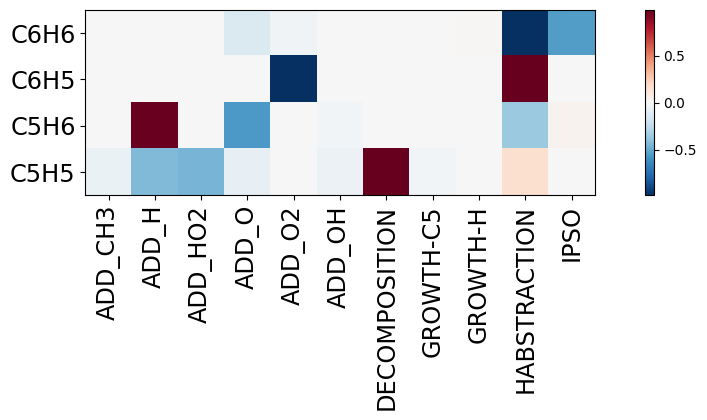

In [23]:
ropa_type = 'local'
local_value = 0.1
species_list =['C6H6','C6H5','C5H6','C5H5']
threshs =[1e-2]     # threshold for minimum flux
n_of_rxns = 200   # max n of rxns to consider for flux (default: 100)
sortlists = [['classtype']] # classtype, speciestype, reactiontype, bimoltype (R+R, RSR+RSR, M+M, ETC) 
                         # sum if both apply and sort by this criteria
simul_fld = simul_flds['example-c6h6']

sortdfs = process_classes(simul_fld, 
            kin_xml_fld, 
            rxns_sorted,
            species_list,
            sortlists,
            ropa_type,
            local_value=local_value,
            threshs = threshs,
            n_of_rxns=n_of_rxns)

# plot heatmap
fig = plot_heatmap(sortdfs[0], symmetricaxis = True, dftype = 'flux')

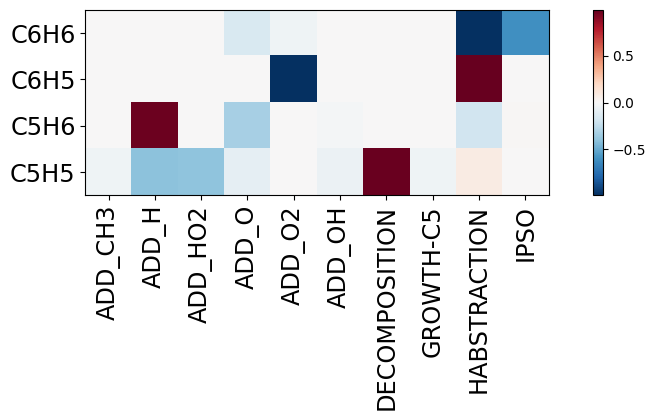

In [24]:
ropa_type = 'region'
lower_value = 0.01
upper_value = 0.1
species_list =['C6H6','C6H5','C5H6','C5H5']
threshs = [1e-2]     # threshold for minimum flux
n_of_rxns = 200   # max n of rxns to consider for flux (default: 100)
sortlists = [['classtype']] # classtype, speciestype, reactiontype, bimoltype (R+R, RSR+RSR, M+M, ETC) 
                         # sum if both apply and sort by this criteria

simul_fld = simul_flds['example-c6h6']


sortdfs = process_classes(simul_fld, 
            kin_xml_fld, 
            rxns_sorted,
            species_list,
            sortlists,
            ropa_type,
            lower_value=lower_value,
            upper_value=upper_value,
            threshs = threshs,
            n_of_rxns=n_of_rxns)

# plot heatmap
fig = plot_heatmap(sortdfs[0], symmetricaxis = True, dftype = 'flux')

### Example 4 - flux analysis in a region by classtype on multiple species types:
region flux analysis as above, but group together the flux of C5, A1, A2
Then do the same but without weighing the flux for each species so that one is able to spot where the flux is larger

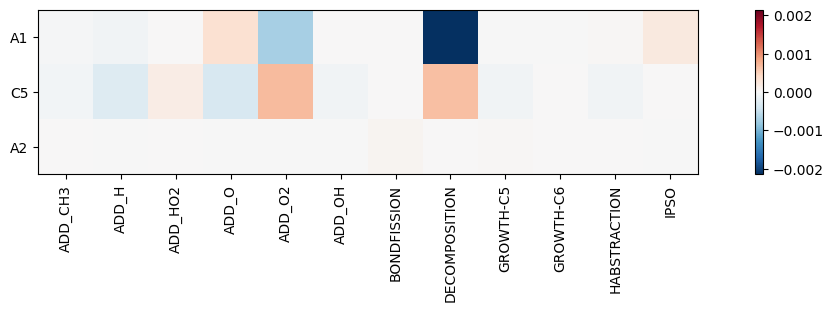

In [25]:
# species and sorting options
species_list =[{'A1':['C6H6', 'C6H5', 'C6H5OH', 'C6H5O']}, {'C5': ['C5H6', 'C5H5', 'C5H6OH', 'C5H5O', 'C5H4O']},
               {'A2': ['C10H8', 'INDENE', 'BIPHENYL', 'C12H8']}]
sortlists = [['classtype']] # classtype, speciestype, reactiontype, bimoltype (R+R, RSR+RSR, M+M, ETC) 
                         # sum if both apply and sort by this criteria
simul_fld = simul_flds['example-c6h6']
threshs = [1e-2]
# ropa options
n_of_rxns = 200 #200   # max n of rxns to consider for flux (default: 10)
ropa_type = 'region'
lower_value = 0.01
upper_value = 0.1
mass_ropa = True
weigh = 'false'

sortdf1 = process_classes(simul_fld, 
            kin_xml_fld, 
            rxns_sorted,
            species_list,
            sortlists,
            ropa_type,
            lower_value=lower_value,
            upper_value=upper_value,
            n_of_rxns=n_of_rxns,
            threshs=threshs,
            mass_ropa=mass_ropa,
            weigh = 'false',)

# plot heatmap
fig = plot_heatmap(sortdf1[0], symmetricaxis = True, dftype = 'flux')

### Example 5 - comparison by FDI
calculate flux analysis for multiple simulations, group by class, and build distance triangular matrices to compare. for full methodology, see 10.1016/J.COMBUSTFLAME.2022.112073
Available comparisons: global, by one species (all classes), by one class (all species)

In [27]:
# FDI
# species and sorting options
species_list =[{'A1':['C6H6', 'C6H5', 'C6H5OH', 'C6H5O']}, {'C5': ['C5H6', 'C5H5', 'C5H6OH', 'C5H5O', 'C5H4O']},
               {'A2': ['C10H8', 'INDENE', 'BIPHENYL', 'C12H8']}]
sortlists = [['classtype']] # classtype, speciestype, reactiontype, bimoltype (R+R, RSR+RSR, M+M, ETC) 
                         # sum if both apply and sort by this criteria

threshs = [1e-2]
# ropa options
n_of_rxns = 50 #200   # max n of rxns to consider for flux (default: 10)
ropa_type = 'global'
mass_ropa = True
weigh = 'omegaij' #to get the FDI

# do not edit
omegadf_dct = dict.fromkeys(sim_flds_toFDI.keys())
for simname, simfld in sim_flds_toFDI.items():
    sortdfs = process_classes(simfld, 
                kin_xml_fld, 
                rxns_sorted,
                species_list,
                sortlists,
                ropa_type,
                n_of_rxns=n_of_rxns,
                threshs=threshs,
                mass_ropa=mass_ropa,
                weigh = weigh,
                )
    omegadf_dct[simname] = sortdfs[0]


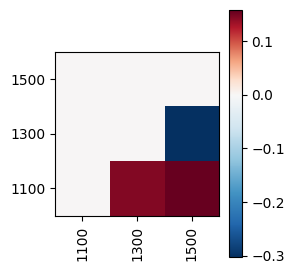

In [28]:
# global
df_FDI_final = FDI(omegadf_dct,
                    fditype='global',
                    )
fig = plot_heatmap(df_FDI_final, symmetricaxis = False, dftype = 'generic')

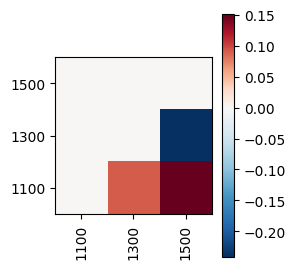

In [29]:
# by species
df_FDI_final = FDI(omegadf_dct,
                    fditype='species',
                    speciesi='A1')
fig = plot_heatmap(df_FDI_final, symmetricaxis = False, dftype = 'generic')

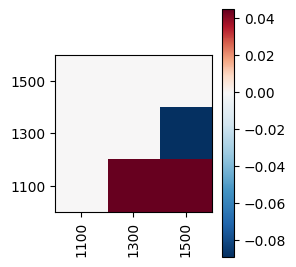

In [30]:
df_FDI_final = FDI(omegadf_dct,
                    fditype='class',
                    classj='DECOMPOSITION')
fig = plot_heatmap(df_FDI_final, symmetricaxis = False, dftype = 'generic')

## Example 6: compare multiple simulations for sets of species
consider sets of simulations and produce synthetic heat maps
Recommended: use normalized flux for easier relative comparisons

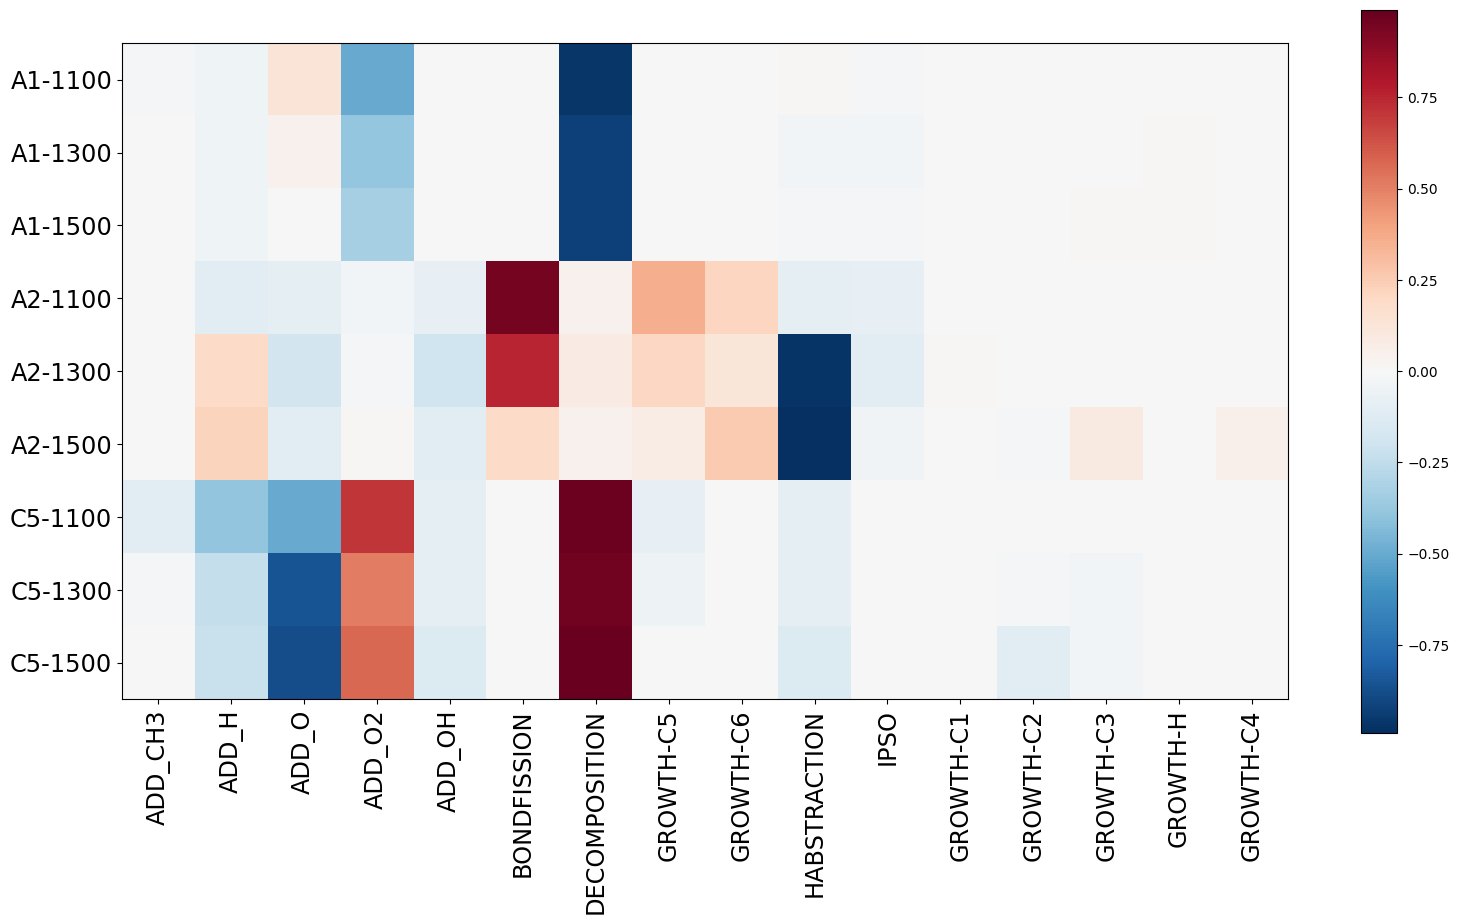

In [5]:
# merge maps of multiple simulations according to the type of species

# species and sorting options
species_list =[{'A1':['C6H6', 'C6H5', 'C6H5OH', 'C6H5O']}, {'C5': ['C5H6', 'C5H5', 'C5H6OH', 'C5H5O', 'C5H4O']},
               {'A2': ['C10H8', 'INDENE', 'BIPHENYL', 'C12H8']}]
sortlists = [['classtype']] # classtype, speciestype, reactiontype, bimoltype (R+R, RSR+RSR, M+M, ETC) 
                         # sum if both apply and sort by this criteria

threshs = [1e-2]
# ropa options
n_of_rxns = 50 #200   # max n of rxns to consider for flux (default: 10)
ropa_type = 'global'
mass_ropa = False

# do not edit
all_dct = dict.fromkeys(sim_flds_toFDI.keys())
for simname, simfld in sim_flds_toFDI.items():
    sortdfs = process_classes(simfld, 
                kin_xml_fld, 
                rxns_sorted,
                species_list,
                sortlists,
                ropa_type,
                n_of_rxns=n_of_rxns,
                threshs=threshs,
                mass_ropa=mass_ropa,
                )
    all_dct[simname] = sortdfs[0]
    

merged_dct = merge_maps_byspecies(all_dct)
fig = plot_heatmap(merged_dct, symmetricaxis = True, dftype = 'flux')

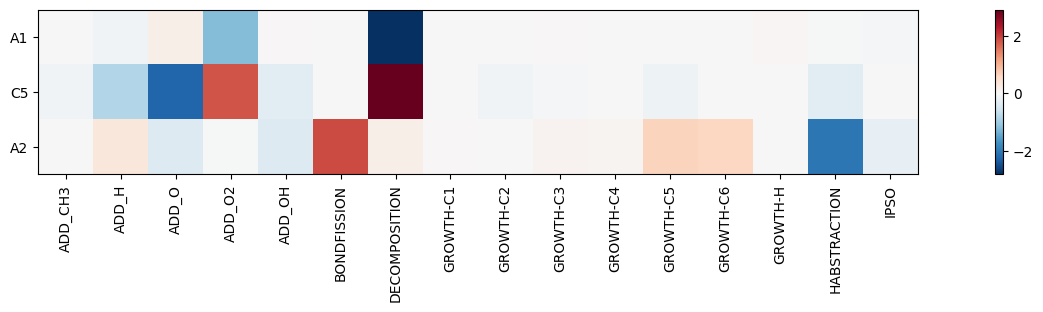

In [6]:
# sum the fluxes instead of comparing them
merged_dct = merge_maps_byspecies(all_dct, tosum = True)
fig = plot_heatmap(merged_dct, symmetricaxis = False, dftype = 'flux')